## LangGraph End-to-End App

In [6]:
import os
from dotenv import load_dotenv
import cassio
from pathlib import Path

load_dotenv()

SECURE_BUNDLE_PATH = Path(r"C:\Users\user\Desktop\LangGraph-app\astra-bundle.zip")


print(f"Looking for file at: {SECURE_BUNDLE_PATH.absolute()}")

ASTRA_DB_APP_TOKEN=os.getenv("ASTRA_DB_APP_TOKEN")
ASTRA_DB_CLIENT_ID=os.getenv("ASTRA_DB_CLIENT_ID")
# Verify that the file exists before passing it to Cassio
if os.path.exists(SECURE_BUNDLE_PATH):
    print("File found, initializing Cassio...")
    
    # Open the file in binary read mode if needed
    with open(SECURE_BUNDLE_PATH, 'rb') as bundle_file:
        # Pass the file handler to Cassio (Cassio should support this)
        cassio.init(token=ASTRA_DB_APP_TOKEN, database_id=ASTRA_DB_CLIENT_ID, secure_connect_bundle=bundle_file)
else:
    print(f"File not found at: {SECURE_BUNDLE_PATH}")

Looking for file at: C:\Users\user\Desktop\LangGraph-app\astra-bundle.zip
File not found at: C:\Users\user\Desktop\LangGraph-app\astra-bundle.zip


In [7]:
# Get fb ads - mock function

def get_facebook_ads():
    """
    Mock function to simulate fetching Facebook ads.

    Returns:
        List[Dict]: A list of ad dictionaries with text and HTML (containing video link).
    """
    ads = [
        {
            "ad_text": "Huge discount on shoes! Watch our promo video.",
            "html": "<div><a href='https://facebook.com/ads/video1'>Watch</a></div>"
        },
        {
            "ad_text": "Try our smart gadgets today!",
            "html": "<div><a href='https://facebook.com/ads/video2'>Demo</a></div>"
        }
    ]
    print("[Node 1] Retrieved Facebook ads.")
    return {"ads": ads}


In [8]:
# extract_urls.py
import re

def extract_video_urls(state):
    """
    Mock function to extract video URLs from Facebook ads HTML.

    Args:
        state (dict): LangGraph state containing 'ads' key.

    Returns:
        dict: Updated state with 'video_ads' containing ad text and video URLs.
    """
    ads = state.get("ads", [])
    video_ads = []

    for ad in ads:
        html = ad.get("html", "")
        match = re.search(r"https://facebook\.com/ads/video\d+", html)
        if match:
            video_ads.append({
                "ad_text": ad["ad_text"],
                "video_url": match.group(0)
            })

    print(f"[Node 2] Extracted {len(video_ads)} video URLs.")
    return {"video_ads": video_ads}


In [15]:
def download_video(state):
    """
    Mock function to 'download' video from URLs.
    This just simulates download by creating a fake local path.

    Args:
        state (dict): Contains 'video_ads' from previous node.

    Returns:
        dict: Updated state with 'video_paths'.
    """
    video_ads = state.get("video_ads", [])
    video_paths = []

    for i, ad in enumerate(video_ads):
        # Pretend we're downloading and saving a video locally
        fake_path = f"/mock/path/video_{i}.mp4"
        video_paths.append({
            "ad_text": ad["ad_text"],
            "video_url": ad["video_url"],
            "local_path": fake_path
        })

    print(f"[Node 3] Mock downloaded {len(video_paths)} videos.")
    return {"video_paths": video_paths}


In [ ]:
def extract_frames(state):
    """
    Mock function to extract 5 frames from each video.

    Args:
        state (dict): Contains 'video_paths'.

    Returns:
        dict: Updated state with 'frames'.
    """
    video_paths = state.get("video_paths", [])
    frames = []

    for video in video_paths:
        frame_list = [f"{video['local_path']}_frame_{i}.jpg" for i in range(5)]
        frames.append({
            "ad_text": video["ad_text"],
            "video_url": video["video_url"],
            "frames": frame_list
        })

    print(f"[Node 4] Extracted 5 mock frames per video.")
    return {"frames": frames}


In [ ]:
def transcribe_video(state):
    """
    Mock transcription using OpenAI's Whisper (simulated).
    
    Args:
        state (dict): Contains 'video_paths'.

    Returns:
        dict: Updated state with 'transcriptions'.
    """
    video_paths = state.get("video_paths", [])
    transcriptions = []

    for video in video_paths:
        # Simulate transcription text
        fake_transcript = f"Mock transcript for {video['local_path']}"
        transcriptions.append({
            "video_url": video["video_url"],
            "transcript": fake_transcript
        })

    print(f"[Node 5] Transcribed {len(transcriptions)} videos.")
    return {"transcriptions": transcriptions}


In [ ]:
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma

# Mock embedding function (will be replaced with OpenAIEmbeddings in production)
class MockEmbeddingFunction:
    def embed_documents(self, texts):
        return [[0.1] * 1536 for _ in texts]

    def embed_query(self, text):
        return [0.1] * 1536

# Setup vectorstore
vectorstore = Chroma(
    collection_name="video_knowledge_base",
    embedding_function=MockEmbeddingFunction()
)

# Node function to embed + store + return retriever
def embed_and_store_video_data(state):
    """
    Combines transcript and frame analysis into a single document,
    embeds it, stores it in ChromaDB, and returns a retriever.
    
    Args:
        state (dict): Must contain 'transcriptions' and 'frame_analysis'.
    
    Returns:
        dict: Updated state including a retriever.
    """
    transcriptions = state.get("transcriptions", [])
    frame_analysis = state.get("frame_analysis", [])

    for i, transcript_obj in enumerate(transcriptions):
        url = transcript_obj["video_url"]
        transcript = transcript_obj["transcript"]

        # Find corresponding frame analysis
        analysis = next((item["results"] for item in frame_analysis if item["video_url"] == url), [])

        # Combine text
        combined_text = f"Transcript:\n{transcript}\n\nFrame Analysis:\n" + "\n".join(analysis)

        # Store as LangChain Document
        doc = Document(
            page_content=combined_text,
            metadata={"source": url, "type": "facebook_video_ad"}
        )

        vectorstore.add_documents([doc])
        print(f"[Node 7] Embedded and stored video: {url}")

    # Create retriever and return
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
    return {"retriever": retriever}


C:\Users\user\AppData\Local\Temp\ipykernel_32\1022398805.py:13: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [25]:
def analyze_transcriptions(state):
    """
    Mock function to analyze video transcriptions.

    Args:
        state (dict): Should contain 'transcriptions' key.

    Returns:
        dict: Adds 'transcript_analysis' to state.
    """
    transcriptions = state.get("transcriptions", [])
    transcript_analysis = []

    for item in transcriptions:
        video_url = item["video_url"]
        transcript = item["transcript"]

        # Mock NLP analysis output
        analysis_result = {
            "video_url": video_url,
            "insights": {
                "detected_tone": "friendly",
                "call_to_action": "Sign up now!",
                "intent": "Promotional"
            }
        }
        transcript_analysis.append(analysis_result)

    print(f"[Node 8] Analyzed {len(transcript_analysis)} transcriptions.")
    return {"transcript_analysis": transcript_analysis}


In [26]:
def analyze_frames(state):
    """
    Mock visual frame analysis.

    Args:
        state (dict): Contains 'frames'.

    Returns:
        dict: Updated state with 'frame_analysis'.
    """
    frame_batches = state.get("frames", [])
    analysis_results = []

    for batch in frame_batches:
        results = [f"Analysis for {frame}" for frame in batch["frames"]]
        analysis_results.append({
            "video_url": batch["video_url"],
            "results": results
        })

    print(f"[Node 6] Analyzed frames for {len(analysis_results)} videos.")
    return {"frame_analysis": analysis_results}


In [27]:
import openai
import base64
from typing import List
from typing_extensions import TypedDict
from io import BytesIO
from PIL import Image

# Set up OpenAI API key
openai.api_key = 'your-api-key-here'

def base64_to_binary(base64_data: str) -> bytes:
    """
    Converts base64-encoded image data to binary.
    
    Args:
        base64_data (str): Base64-encoded image data.
    
    Returns:
        bytes: Binary image data.
    """
    # Decode the base64 string to binary data
    binary_data = base64.b64decode(base64_data)
    return binary_data

def analyze_image(base64_image: str) -> str:
    """
    Analyzes the image using OpenAI's Image model.
    
    Args:
        base64_image (str): Base64-encoded image data.
    
    Returns:
        str: The result from the image analysis (e.g., a description of the image).
    """
    # Convert base64 image data to binary
    binary_image_data = base64_to_binary(base64_image)

    # Using OpenAI's Image API to analyze the image
    response = openai.Image.create(
        prompt="Give me a single word that represents a characteristic of this advertising image to characterize it.",
        n=1,
        images=[{
            "file": binary_image_data,
            "filename": "ad_image.jpg"
        }]
    )
    
    # Extracting the insights
    image_analysis_result = response.get("data", [{}])[0].get("text", "")
    
    return image_analysis_result

class GraphState(TypedDict):
    """
    Represents the state of our LangGraph agent.

    Attributes:
        question: Input query or task.
        generation: Output or LLM-generated content.
        documents: Supporting docs or evidence list.
    """
    question: str
    generation: str
    documents: List[str]

def analyze_ad(ad_transcript: str, ad_visual_summary: str, base64_image: str) -> GraphState:
    """
    Analyzes ad insights using OpenAI model and returns the result as a GraphState.
    
    Args:
        ad_transcript (str): Audio description or transcript summary.
        ad_visual_summary (str): Video description or visual summary.
        base64_image (str): Base64-encoded image data for visual analysis.
    
    Returns:
        GraphState: A dictionary representing the analysis state.
    """
    # Analyze the image for additional insights
    image_analysis_result = analyze_image(base64_image)
    
    # Construct the prompt for OpenAI analysis based on both transcript, visual summary, and image analysis
    prompt = f"""
    STEP 1: Analyze the ad insights below.
    Ad Transcript Summary: {ad_transcript}
    Visual Summary: {ad_visual_summary}
    Image Analysis: {image_analysis_result}
    
    Now answer these clearly:
    1. What is the **main hook line or pattern** used in this ad? Why did it work?
    2. What is the **tone** of the ad (e.g., emotional, confident, hype)?
    3. What **power phrases or emotional angles** stood out?
    4. What **gestures, expressions, or camera angles or visual things** were impactful?
    
    Please reply in the following JSON format:
    {{
        "hook": "...",
        "tone": "...",
        "power_phrases": "...",
        "visual": "..."
    }}
    """
    
    # Send the prompt to OpenAI model (GPT or similar)
    response = openai.Completion.create(
        model="gpt-4o",
        prompt=prompt,
        max_tokens=150
    )
    
    # Extracting the insights from the response
    analysis_result = response.choices[0].text.strip()
    
    # Creating the GraphState to represent the result
    graph_state: GraphState = {
        "question": "What insights can we extract from this ad?",
        "generation": analysis_result,
        "documents": [ad_transcript, ad_visual_summary, image_analysis_result]
    }
    
    return graph_state


In [31]:
from langgraph.graph import StateGraph, END, START



# Define nodes
builder = StateGraph(GraphState)

# Add nodes to the graph
builder.add_node("Get Facebook Ads", get_facebook_ads)
builder.add_node("Get Video URLs", extract_video_urls)
builder.add_node("Download Video", download_video)
builder.add_node("Transcribe Video", transcribe_video)
builder.add_node("Extract Frames", extract_frames)
builder.add_node("Analyze Transcription", analyze_transcriptions)
builder.add_node("Analyze Frames", analyze_frames)
builder.add_node("Analyze Ad", analyze_ad)

# Define edges
builder.set_entry_point("Get Facebook Ads")
builder.add_edge("Get Facebook Ads", "Get Video URLs")
builder.add_edge("Get Video URLs", "Download Video")

# Split Download Video into two branches
builder.add_edge("Download Video", "Transcribe Video")
builder.add_edge("Download Video", "Extract Frames")

# Analyze branches
builder.add_edge("Transcribe Video", "Analyze Transcription")
builder.add_edge("Extract Frames", "Analyze Frames")

# Join branches at Analyze Ad
builder.add_edge("Analyze Transcription", "Analyze Ad")
builder.add_edge("Analyze Frames", "Analyze Ad")

# End of graph
builder.add_edge("Analyze Ad", END)

# Compile the graph
workflow = builder.compile()



In [34]:
# Visualize the workflow
workflow.get_graph().draw_ascii()

'                   +-----------+                        \r\n                   | __start__ |                        \r\n                   +-----------+                        \r\n                         *                              \r\n                         *                              \r\n                         *                              \r\n               +------------------+                     \r\n               | Get Facebook Ads |                     \r\n               +------------------+                     \r\n                         *                              \r\n                         *                              \r\n                         *                              \r\n                +----------------+                      \r\n                | Get Video URLs |                      \r\n                +----------------+                      \r\n                         *                              \r\n                         *             

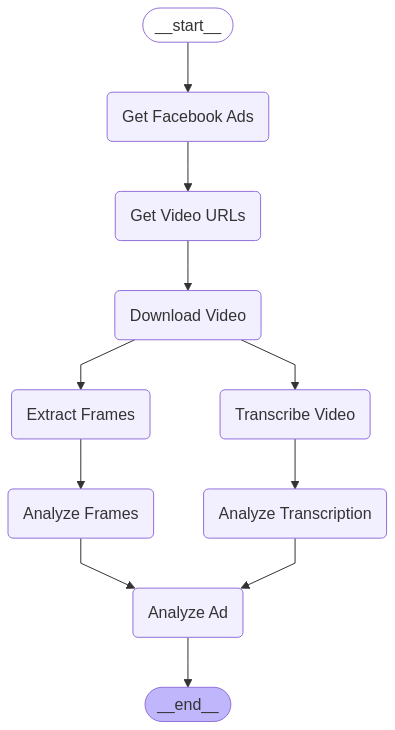

In [35]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass